### Playing with DLC Live

In [1]:
import sys
sys.path.append('../scripts/')
from dataLoader import DLCInterface 
import numpy as np
%load_ext autoreload
%autoreload 2

2024-07-15 12:47:01.032344: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 12:47:01.089218: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 12:47:01.105693: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 12:47:01.373749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Loading DLC 2.3.10...


/home/jakejoseph/anaconda3/envs/DEEPLABCUT_LIVE/lib/python3.9/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
model = DLCInterface('/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/config.yaml')
model.benchmark('/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/videos/napierecrbfatigue_05_31_3_1.mp4',
                '/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/exported-models/DLC_FESFatigue_resnet_50_iteration-2_shuffle-1')

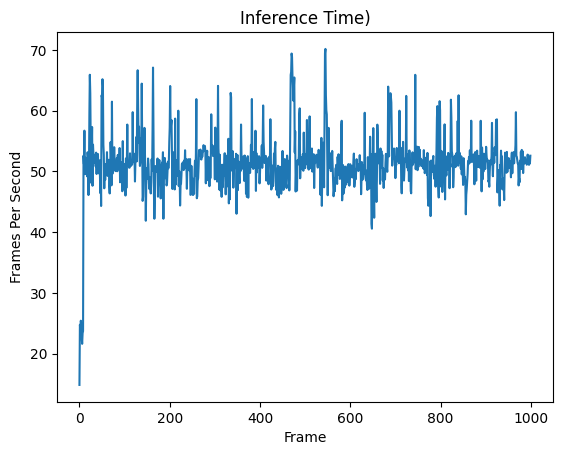

Final accumulated lag: -3.0688 seconds


In [7]:
model.plotInferenceTime('/home/jakejoseph/Desktop/Joseph_Code/stim_behavior/benchmark_results/benchmark_eros_GPU_0.pickle')
lag =  np.cumsum((1/60) -model.inferenceTimes)
print(f"Final accumulated lag: {lag[-1]:.4f} seconds")

### Extracting frame from selected videl

In [1]:
import cv2

def extract_frame(video_path, frame_number):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return None
    
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    
    # Check if frame was successfully read
    if not ret:
        print(f"Error reading frame {frame_number}")
        return None
    
    # Release the video capture object
    cap.release()
    
    # Return the frame as a NumPy array
    return frame

# Example usage
video_path = '/home/jakejoseph/Desktop/ExtensorsSuperCut.mp4'
frame_number = 100  # The frame you want to extract

frame = extract_frame(video_path, frame_number)

if frame is not None:
    print(f"Frame shape: {frame.shape}")
    print(f"Frame data type: {frame.dtype}")
    

Frame shape: (1080, 1920, 3)
Frame data type: uint8


In [3]:
from dlclive import DLCLive
dlc_live = DLCLive('/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/exported-models/DLC_FESFatigue_resnet_50_iteration-2_shuffle-1')
dlc_live.init_inference(frame)
!nvidia-smi
prediction = dlc_live.get_pose(frame)
!nvidia-smi

2024-08-06 10:54:48.045100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:54:48.046460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:54:48.047681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:54:48.048823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:54:48.049935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Tue Aug  6 10:54:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P0             41W /  285W |   10417MiB /  12282MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

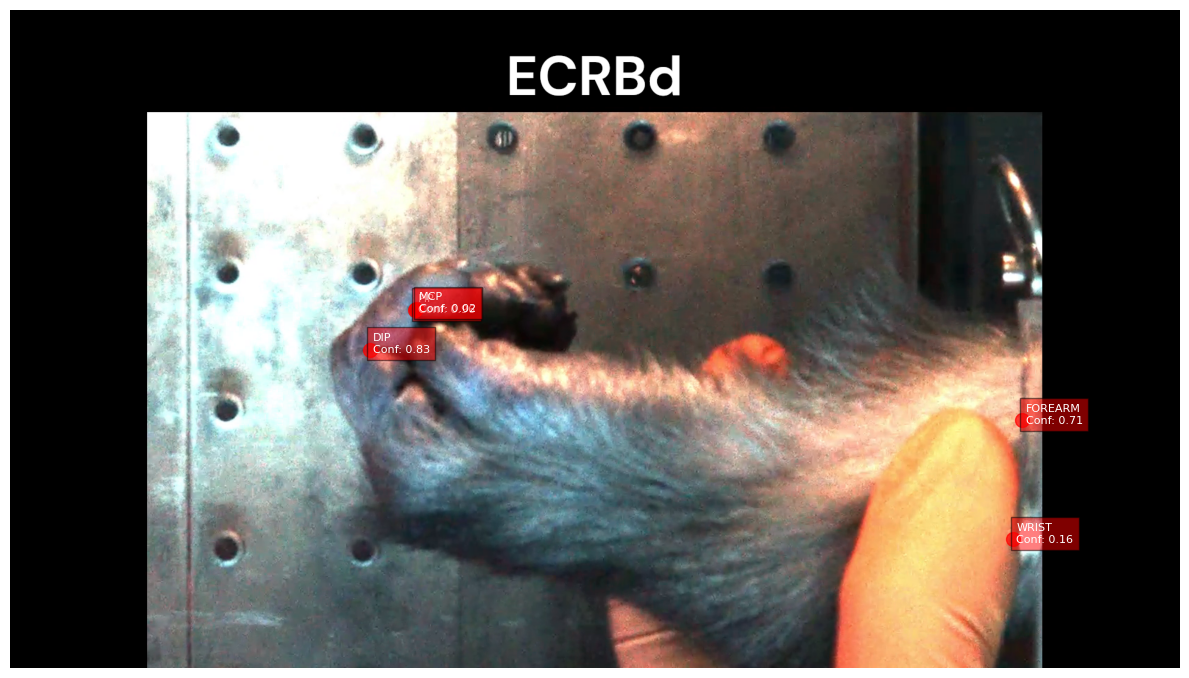

In [4]:
from matplotlib import pyplot as plt
def plot_keypoints(image_array, keypoints):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Display the image
    ax.imshow(image_array)

    joints = ['PIP','DIP','MCP','WRIST','FOREARM']

    # Plot each keypoint
    for i, (x, y, conf) in enumerate(keypoints):
        ax.plot(x, y, 'ro', markersize=10, alpha=0.7)
        ax.text(x+5, y+5, f'{joints[i]}\nConf: {conf:.2f}', color='white', fontsize=8,
                bbox=dict(facecolor='red', alpha=0.5))

    # Set the title and remove axis ticks
    ax.set_axis_off()

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_keypoints(frame, prediction)

In [5]:
from concurrent.futures import ThreadPoolExecutor

dlc_live = DLCLive('/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/exported-models/DLC_FESFatigue_resnet_50_iteration-2_shuffle-1')
dlc_live2 = DLCLive('/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/exported-models/DLC_FESFatigue_resnet_50_iteration-2_shuffle-1')

def process_dlc(dlc, frame):
    dlc.init_inference(frame)
    return dlc.get_pose(frame)

with ThreadPoolExecutor(max_workers=2) as executor:
    future1 = executor.submit(process_dlc, dlc_live, frame)
    future2 = executor.submit(process_dlc, dlc_live2, frame)
    !nvidia-smi
    prediction = future1.result()
    prediction2 = future2.result()

Tue Aug  6 10:55:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   38C    P8              7W /  285W |   10399MiB /  12282MiB |     49%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2024-08-06 10:55:21.201852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:55:21.204044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:55:21.205644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:55:21.207212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-06 10:55:21.208728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [6]:
import multiprocessing as mp
from functools import partial
from dlclive import DLCLive

dlc_live = DLCLive('/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/exported-models/DLC_FESFatigue_resnet_50_iteration-2_shuffle-1')
dlc_live2 = DLCLive('/home/jakejoseph/Desktop/Joseph_Code/FESFatigue-Jake-2024-05-31/exported-models/DLC_FESFatigue_resnet_50_iteration-2_shuffle-1')

def process_dlc(dlc, frame):
    dlc.init_inference(frame)
    return dlc.get_pose(frame)



manager = mp.Manager()
return1 = manager.dict()
return2 = manager.dict()

p1 = mp.Process(target=process_dlc, args=(dlc_live, frame))
p2 = mp.Process(target=process_dlc, args=(dlc_live2, frame))

# Start the processes
p1.start()
p2.start()
!nvidia-smi

# Wait for the processes to finish
p1.join()
p2.join()
!nvidia-smi

print(return1, return2)

Tue Aug  6 10:55:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P8              8W /  285W |   10393MiB /  12282MiB |     50%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2024-08-06 10:55:57.062458: E tensorflow/stream_executor/cuda/cuda_driver.cc:1276] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-08-06 10:55:57.122948: E tensorflow/stream_executor/cuda/cuda_driver.cc:1276] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error


KeyboardInterrupt: 